# Задание 1.2 - Линейный классификатор (Linear classifier)

В этом задании мы реализуем другую модель машинного обучения - линейный классификатор. Линейный классификатор подбирает для каждого класса веса, на которые нужно умножить значение каждого признака и потом сложить вместе.
Тот класс, у которого эта сумма больше, и является предсказанием модели.

В этом задании вы:
- потренируетесь считать градиенты различных многомерных функций
- реализуете подсчет градиентов через линейную модель и функцию потерь softmax
- реализуете процесс тренировки линейного классификатора
- подберете параметры тренировки на практике

На всякий случай, еще раз ссылка на туториал по numpy:  
http://cs231n.github.io/python-numpy-tutorial/

In [1]:
import numpy as np
import matplotlib.pyplot as plt

%matplotlib inline

%load_ext autoreload
%autoreload 2

In [2]:
np.random.choice(100, 3)

array([84, 72, 69])

In [3]:
from dataset import load_svhn, random_split_train_val
from gradient_check import check_gradient
from metrics import multiclass_accuracy 
import linear_classifer

# Как всегда, первым делом загружаем данные

Мы будем использовать все тот же SVHN.

In [4]:
def prepare_for_linear_classifier(train_X, test_X):
    train_flat = train_X.reshape(train_X.shape[0], -1).astype(np.float) / 255.0
    test_flat = test_X.reshape(test_X.shape[0], -1).astype(np.float) / 255.0
    
    # Subtract mean
    mean_image = np.mean(train_flat, axis = 0)
    train_flat -= mean_image
    test_flat -= mean_image
    
    # Add another channel with ones as a bias term
    train_flat_with_ones = np.hstack([train_flat, np.ones((train_X.shape[0], 1))])
    test_flat_with_ones = np.hstack([test_flat, np.ones((test_X.shape[0], 1))])    
    return train_flat_with_ones, test_flat_with_ones
    
train_X, train_y, test_X, test_y = load_svhn("data", max_train=10000, max_test=1000)    
train_X, test_X = prepare_for_linear_classifier(train_X, test_X)
# Split train into train and val
train_X, train_y, val_X, val_y = random_split_train_val(train_X, train_y, num_val = 1000)

<ipython-input-4-4ab6e7a8ed1f>:2: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  train_flat = train_X.reshape(train_X.shape[0], -1).astype(np.float) / 255.0
<ipython-input-4-4ab6e7a8ed1f>:3: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  test_flat = test_X.reshape(test_X.shape[0], -1).astype(np.float) / 255.0


# Играемся с градиентами!

В этом курсе мы будем писать много функций, которые вычисляют градиенты аналитическим методом.

Все функции, в которых мы будем вычислять градиенты, будут написаны по одной и той же схеме.  
Они будут получать на вход точку, где нужно вычислить значение и градиент функции, а на выходе будут выдавать кортеж (tuple) из двух значений - собственно значения функции в этой точке (всегда одно число) и аналитического значения градиента в той же точке (той же размерности, что и вход).
```
def f(x):
    """
    Computes function and analytic gradient at x
    
    x: np array of float, input to the function
    
    Returns:
    value: float, value of the function 
    grad: np array of float, same shape as x
    """
    ...
    
    return value, grad
```

Необходимым инструментом во время реализации кода, вычисляющего градиенты, является функция его проверки. Эта функция вычисляет градиент численным методом и сверяет результат с градиентом, вычисленным аналитическим методом.

Мы начнем с того, чтобы реализовать вычисление численного градиента (numeric gradient) в функции `check_gradient` в `gradient_check.py`. Эта функция будет принимать на вход функции формата, заданного выше, использовать значение `value` для вычисления численного градиента и сравнит его с аналитическим - они должны сходиться.

Напишите часть функции, которая вычисляет градиент с помощью численной производной для каждой координаты. Для вычисления производной используйте так называемую two-point formula (https://en.wikipedia.org/wiki/Numerical_differentiation):

![image](https://wikimedia.org/api/rest_v1/media/math/render/svg/22fc2c0a66c63560a349604f8b6b39221566236d)

Все функции приведенные в следующей клетке должны проходить gradient check.

In [5]:
# TODO: Implement check_gradient function in gradient_check.py
# All the functions below should pass the gradient check

def square(x):
    return float(x*x), 2*x

check_gradient(square, np.array([3.0]))

def array_sum(x):
    assert x.shape == (2,), x.shape
    return np.sum(x), np.ones_like(x)

check_gradient(array_sum, np.array([3.0, 2.0]))

def array_2d_sum(x):
    assert x.shape == (2,2)
    return np.sum(x), np.ones_like(x)

check_gradient(array_2d_sum, np.array([[3.0, 2.0], [1.0, 0.0]]))


(9.0000600001, array([6.00002]))
(8.999940000099999, array([5.99998]))
6.0
6.000000000039306
Gradient check passed!
(5.00001, array([1., 1.]))
(4.99999, array([1., 1.]))
1.0
0.9999999999621422
(5.00001, array([1., 1.]))
(4.99999, array([1., 1.]))
1.0
0.9999999999621422
Gradient check passed!
(6.00001, array([[1., 1.],
       [1., 1.]]))
(5.99999, array([[1., 1.],
       [1., 1.]]))
1.0
0.9999999999621422
(6.00001, array([[1., 1.],
       [1., 1.]]))
(5.99999, array([[1., 1.],
       [1., 1.]]))
1.0
0.9999999999621422
(6.00001, array([[1., 1.],
       [1., 1.]]))
(5.99999, array([[1., 1.],
       [1., 1.]]))
1.0
0.9999999999621422
(6.00001, array([[1., 1.],
       [1., 1.]]))
(5.99999, array([[1., 1.],
       [1., 1.]]))
1.0
0.9999999999621422
Gradient check passed!


True

## Начинаем писать свои функции, считающие аналитический градиент

Теперь реализуем функцию softmax, которая получает на вход оценки для каждого класса и преобразует их в вероятности от 0 до 1:
![image](https://wikimedia.org/api/rest_v1/media/math/render/svg/e348290cf48ddbb6e9a6ef4e39363568b67c09d3)

**Важно:** Практический аспект вычисления этой функции заключается в том, что в ней учавствует вычисление экспоненты от потенциально очень больших чисел - это может привести к очень большим значениям в числителе и знаменателе за пределами диапазона float.

К счастью, у этой проблемы есть простое решение -- перед вычислением softmax вычесть из всех оценок максимальное значение среди всех оценок:
```
predictions -= np.max(predictions)
```
(подробнее здесь - http://cs231n.github.io/linear-classify/#softmax, секция `Practical issues: Numeric stability`)

In [6]:
# TODO Implement softmax and cross-entropy for single sample
probs = linear_classifer.softmax(np.array([-10, 0, 10]))
print(probs)
# Make sure it works for big numbers too!
probs = linear_classifer.softmax(np.array([1000, 0, 0]))
print(probs)
assert np.isclose(probs[0], 1.0)



[2.06106005e-09 4.53978686e-05 9.99954600e-01]
[1. 0. 0.]


Кроме этого, мы реализуем cross-entropy loss, которую мы будем использовать как функцию ошибки (error function).
В общем виде cross-entropy определена следующим образом:
![image](https://wikimedia.org/api/rest_v1/media/math/render/svg/0cb6da032ab424eefdca0884cd4113fe578f4293)

где x - все классы, p(x) - истинная вероятность принадлежности сэмпла классу x, а q(x) - вероятность принадлежности классу x, предсказанная моделью.  
В нашем случае сэмпл принадлежит только одному классу, индекс которого передается функции. Для него p(x) равна 1, а для остальных классов - 0. 

Это позволяет реализовать функцию проще!

In [7]:
probs = linear_classifer.softmax(np.array([-5, 0, 5]))
linear_classifer.cross_entropy_loss(probs, 1)


5.006760443547122

In [8]:
4.50940412e-05, 6.69254912e-03, 9.93262357e-01

(4.50940412e-05, 0.00669254912, 0.993262357)

In [9]:
2.718281828**-0.006760443547121171

0.9932623568433084

После того как мы реализовали сами функции, мы можем реализовать градиент.

Оказывается, что вычисление градиента становится гораздо проще, если объединить эти функции в одну, которая сначала вычисляет вероятности через softmax, а потом использует их для вычисления функции ошибки через cross-entropy loss.

Эта функция `softmax_with_cross_entropy` будет возвращает и значение ошибки, и градиент по входным параметрам. Мы проверим корректность реализации с помощью `check_gradient`.

In [10]:
# TODO Implement combined function or softmax and cross entropy and produces gradient
loss, grad = linear_classifer.softmax_with_cross_entropy(np.array([1, 0, 0]).reshape(1, 3), np.array([1]))
check_gradient(lambda x: linear_classifer.softmax_with_cross_entropy(x, np.array([1])), np.array([1, 0, 0]).reshape(1, 3), np.float)


<ipython-input-10-ea4b88edfaa3>:3: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  check_gradient(lambda x: linear_classifer.softmax_with_cross_entropy(x, np.array([1])), np.array([1, 0, 0]).reshape(1, 3), np.float)


AssertionError: 

В качестве метода тренировки мы будем использовать стохастический градиентный спуск (stochastic gradient descent или SGD), который работает с батчами сэмплов. 

Поэтому все наши фукнции будут получать не один пример, а батч, то есть входом будет не вектор из `num_classes` оценок, а матрица размерности `batch_size, num_classes`. Индекс примера в батче всегда будет первым измерением.

Следующий шаг - переписать наши функции так, чтобы они поддерживали батчи.

Финальное значение функции ошибки должно остаться числом, и оно равно среднему значению ошибки среди всех примеров в батче.

In [11]:
# TODO Extend combined function so it can receive a 2d array with batch of samples
np.random.seed(42)
# Test batch_size = 1 
num_classes = 4
batch_size = 1
predictions = np.random.randint(-1, 3, size=(batch_size, num_classes)).astype(np.float)
target_index = np.random.randint(0, num_classes, size=(batch_size, 1)).astype(np.int)

check_gradient(lambda x: linear_classifer.softmax_with_cross_entropy(x, target_index), predictions)

#linear_classifer.softmax_with_cross_entropy(predictions, target_index)
# Test batch_size = 3
num_classes = 4
batch_size = 3
predictions = np.random.randint(-1, 3, size=(batch_size, num_classes)).astype(np.float)
target_index = np.random.randint(0, num_classes, size=(batch_size, 1)).astype(np.int)


check_gradient(lambda x: linear_classifer.softmax_with_cross_entropy(x, target_index), predictions)
#linear_classifer.softmax_with_cross_entropy(predictions, target_index)
# Make sure maximum subtraction for numberic stability is done separately for every sample in the batch
probs = linear_classifer.softmax(np.array([[20,0,0], [1000, 0, 0]]))
assert np.all(np.isclose(probs[:, 0], 1.0))

(array([[3.57972628]]), array([[ 0.20603355,  0.56005164, -0.97211667,  0.20603148]]))
(array([[3.57972216]]), array([[ 0.20603027,  0.56005395, -0.97211656,  0.20603233]]))
0.20603190919001857
[[0.20603191]]
(array([[3.57972982]]), array([[ 0.20603076,  0.56005526, -0.97211677,  0.20603076]]))
(array([[3.57971862]]), array([[ 0.20603306,  0.56005033, -0.97211646,  0.20603306]]))
0.5600527948339517
[[0.56005279]]
(array([[3.5797145]]), array([[ 0.20603185,  0.56005264, -0.97211634,  0.20603185]]))
(array([[3.57973394]]), array([[ 0.20603197,  0.56005295, -0.97211688,  0.20603197]]))
-0.9721166132139888
[[-0.97211661]]
(array([[3.57972628]]), array([[ 0.20603148,  0.56005164, -0.97211667,  0.20603355]]))
(array([[3.57972216]]), array([[ 0.20603233,  0.56005395, -0.97211656,  0.20603027]]))
0.20603190919001857
[[0.20603191]]
Gradient check passed!
(array([[1.38353545],
       [1.2142833 ],
       [3.88280282]]), array([[ 0.68145473,  0.03392729,  0.03392729, -0.74930932],
       [ 0.1092

<ipython-input-11-760b6f0c9c0f>:6: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  predictions = np.random.randint(-1, 3, size=(batch_size, num_classes)).astype(np.float)
<ipython-input-11-760b6f0c9c0f>:7: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.

ValueError: The truth value of an array with more than one element is ambiguous. Use a.any() or a.all()

### Наконец, реализуем сам линейный классификатор!

softmax и cross-entropy получают на вход оценки, которые выдает линейный классификатор.

Он делает это очень просто: для каждого класса есть набор весов, на которые надо умножить пиксели картинки и сложить. Получившееся число и является оценкой класса, идущей на вход softmax.

Таким образом, линейный классификатор можно представить как умножение вектора с пикселями на матрицу W размера `num_features, num_classes`. Такой подход легко расширяется на случай батча векторов с пикселями X размера `batch_size, num_features`:

`predictions = X * W`, где `*` - матричное умножение.

Реализуйте функцию подсчета линейного классификатора и градиентов по весам `linear_softmax` в файле `linear_classifer.py`

In [12]:
# TODO Implement linear_softmax function that uses softmax with cross-entropy for linear classifier
batch_size = 2
num_classes = 2
num_features = 3
np.random.seed(42)
W = np.random.randint(-1, 3, size=(num_features, num_classes)).astype(np.float)
X = np.random.randint(-1, 3, size=(batch_size, num_features)).astype(np.float)
target_index = np.ones(batch_size, dtype=np.int)

loss, dW = linear_classifer.linear_softmax(X, W, target_index)
#print(lambda w: linear_classifer.linear_softmax(X, w, target_index), W)
check_gradient(lambda w: linear_classifer.linear_softmax(X, w, target_index), W)

(array([2.1269192 , 0.04858735]), array([[-0.88079603,  0.88079603],
       [-0.83337015,  0.83337015],
       [ 0.9282219 , -0.9282219 ]]))
(array([2.12693682, 0.04858735]), array([[-0.88079813,  0.88079813],
       [-0.83337225,  0.83337225],
       [ 0.928224  , -0.928224  ]]))
-0.8807970779778823
[-0.88079708  0.        ]


<ipython-input-12-c7d5e1cf0271>:6: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  W = np.random.randint(-1, 3, size=(num_features, num_classes)).astype(np.float)
<ipython-input-12-c7d5e1cf0271>:7: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  X = np.random.randint(-1, 3, size=(batch_size, num_features)).astype(np.float)
<ipython-input-12-c

ValueError: The truth value of an array with more than one element is ambiguous. Use a.any() or a.all()

И теперь регуляризация
Мы будем использовать L2 regularization для весов как часть общей функции ошибки.

Напомним, L2 regularization определяется как

l2_reg_loss = regularization_strength * sumij W[i, j]2

Реализуйте функцию для его вычисления и вычисления соотвествующих градиентов.

In [13]:
# TODO Implement l2_regularization function that implements loss for L2 regularization
linear_classifer.l2_regularization(W, 0.01)
check_gradient(lambda w: linear_classifer.l2_regularization(w, 0.01), W)
#print(lambda w: linear_classifer.l2_regularization(w, 0.01), W)

(0.060000100000500003, array([[ 0.0100001,  0.02     ],
       [-0.01     ,  0.01     ],
       [ 0.01     ,  0.02     ]]))
(0.0599999000005, array([[ 0.0099999,  0.02     ],
       [-0.01     ,  0.01     ],
       [ 0.01     ,  0.02     ]]))
0.01
0.010000000000287557
(0.0600002000005, array([[ 0.01     ,  0.0200001],
       [-0.01     ,  0.01     ],
       [ 0.01     ,  0.02     ]]))
(0.0599998000005, array([[ 0.01     ,  0.0199999],
       [-0.01     ,  0.01     ],
       [ 0.01     ,  0.02     ]]))
0.02
0.019999999999881224
(0.0599999000005, array([[ 0.01     ,  0.02     ],
       [-0.0099999,  0.01     ],
       [ 0.01     ,  0.02     ]]))
(0.060000100000500003, array([[ 0.01     ,  0.02     ],
       [-0.0100001,  0.01     ],
       [ 0.01     ,  0.02     ]]))
-0.01
-0.010000000000287557
(0.060000100000500003, array([[ 0.01     ,  0.02     ],
       [-0.01     ,  0.0100001],
       [ 0.01     ,  0.02     ]]))
(0.0599999000005, array([[ 0.01     ,  0.02     ],
       [-0.01     ,  

True

# Тренировка!

In [696]:
a = np.zeros((3,2,4))

In [697]:
a

array([[[0., 0., 0., 0.],
        [0., 0., 0., 0.]],

       [[0., 0., 0., 0.],
        [0., 0., 0., 0.]],

       [[0., 0., 0., 0.],
        [0., 0., 0., 0.]]])

In [701]:
np.array([[1, 2], [3, 4], [5, 6], [7, 8]]).shape

(4, 2)

In [706]:
for i in range(3):
    a[i, :, :] = np.ones((2, 4)) + np.array([[1, 2, 3, 4], [5, 6, 7, 8]])
print(a)

[[[2. 3. 4. 5.]
  [6. 7. 8. 9.]]

 [[2. 3. 4. 5.]
  [6. 7. 8. 9.]]

 [[2. 3. 4. 5.]
  [6. 7. 8. 9.]]]


Градиенты в порядке, реализуем процесс тренировки!

In [693]:
# TODO: Implement LinearSoftmaxClassifier.fit function
classifier = linear_classifer.LinearSoftmaxClassifier()
loss_history = classifier.fit(train_X, train_y, epochs=10, learning_rate=1e-3, batch_size=300, reg=1e1)

9000
3073
10


/Users/dimasyrovitsky/dlcourse_ai/assignments/assignment1/linear_classifer.py:40: RuntimeWarning: divide by zero encountered in log
  return (- np.log(probs[target_index]))
/Users/dimasyrovitsky/dlcourse_ai/assignments/assignment1/linear_classifer.py:227: RuntimeWarning: overflow encountered in double_scalars
  loss[k] = cross_entropy_loss(sm[k], y[batches_indices[j]][k]) +  reg * np.sum(self.W**2)
/Users/dimasyrovitsky/dlcourse_ai/assignments/assignment1/linear_classifer.py:227: RuntimeWarning: overflow encountered in square
  loss[k] = cross_entropy_loss(sm[k], y[batches_indices[j]][k]) +  reg * np.sum(self.W**2)


(300, 3073, 10)
[[[ 2.06233364e+207 -2.89270534e+207 -2.04443625e+207 ...
   -1.09583961e+206 -2.21129209e+207  1.91068561e+207]
  [ 1.65564196e+207  5.89118276e+207 -3.55602681e+207 ...
   -2.33924276e+207  4.99081727e+205  2.03409117e+207]
  [ 8.91194101e+206  2.64265123e+206 -8.46839611e+206 ...
   -1.41131550e+207 -3.05344169e+207  2.58066933e+205]
  ...
  [ 1.70326278e+207  2.98870641e+207  8.72500434e+206 ...
   -2.63092226e+207 -4.10313384e+207 -2.85526166e+207]
  [ 2.10876501e+207  5.46219828e+207  9.69516340e+205 ...
   -4.21859531e+207  1.34230780e+207  4.97228999e+207]
  [-4.23614150e+207  1.60952527e+208  1.04150295e+208 ...
   -5.54965370e+207 -6.07698667e+207 -2.12790098e+207]]

 [[ 2.06233364e+207 -2.89270534e+207 -2.04443625e+207 ...
   -1.09583961e+206 -2.21129209e+207  1.91068561e+207]
  [ 1.65564196e+207  5.89118276e+207 -3.55602681e+207 ...
   -2.33924276e+207  4.99081727e+205  2.03409117e+207]
  [ 8.91194101e+206  2.64265123e+206 -8.46839611e+206 ...
   -1.41131550

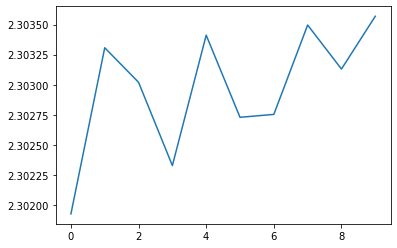

In [604]:
# let's look at the loss history!
plt.plot(loss_history)

In [605]:
# Let's check how it performs on validation set
pred = classifier.predict(val_X)
accuracy = multiclass_accuracy(pred, val_y)
print(val_X.shape)
print(val_X)
print("Accuracy: ", accuracy)

# Now, let's train more and see if it performs better
classifier.fit(train_X, train_y, epochs=100, learning_rate=1e-3, batch_size=300, reg=1e1)
pred = classifier.predict(val_X)
accuracy = multiclass_accuracy(pred, val_y)
print("Accuracy after training for 100 epochs: ", accuracy)

(1000,)
(1000, 3073)
[[-0.28583216 -0.30627255 -0.24730667 ...  0.12864196  0.12063333
   1.        ]
 [-0.05053804 -0.00823333  0.01543843 ... -0.23606392 -0.23230784
   1.        ]
 [-0.01524392 -0.01999804 -0.10220863 ...  0.38354392  0.39906471
   1.        ]
 ...
 [-0.09759686 -0.05137059 -0.07867922 ...  0.45805373  0.37945686
   1.        ]
 [ 0.14554039  0.16823725  0.23112471 ... -0.19684824 -0.15779804
   1.        ]
 [-0.19563608 -0.22784118 -0.15318902 ... -0.28312275 -0.20485686
   1.        ]]
Accuracy:  nan
Epoch 0, loss: 2.302669
Epoch 1, loss: 2.302346
Epoch 2, loss: 2.303133
Epoch 3, loss: 2.301955
Epoch 4, loss: 2.302710
Epoch 5, loss: 2.303081
Epoch 6, loss: 2.302524
Epoch 7, loss: 2.302395
Epoch 8, loss: 2.303378
Epoch 9, loss: 2.302639
Epoch 10, loss: 2.302793
Epoch 11, loss: 2.302409
Epoch 12, loss: 2.303378
Epoch 13, loss: 2.302859
Epoch 14, loss: 2.303331
Epoch 15, loss: 2.301604
Epoch 16, loss: 2.301776
Epoch 17, loss: 2.303080
Epoch 18, loss: 2.302446
Epoch 1

### Как и раньше, используем кросс-валидацию для подбора гиперпараметтов.

В этот раз, чтобы тренировка занимала разумное время, мы будем использовать только одно разделение на тренировочные (training) и проверочные (validation) данные.

Теперь нам нужно подобрать не один, а два гиперпараметра! Не ограничивайте себя изначальными значениями в коде.  
Добейтесь точности более чем **20%** на проверочных данных (validation data).

In [609]:
num_epochs = 200
batch_size = 300

learning_rates = [1e-3, 1e-4, 1e-5]
reg_strengths = [1e-4, 1e-5, 1e-6]

best_classifier = None
best_val_accuracy = None
best_classifier = linear_classifer.LinearSoftmaxClassifier()
loss_history = classifier.fit(train_X, train_y, epochs=10, learning_rate=1e-3, batch_size=300, reg=1e1)
# TODO use validation set to find the best hyperparameters
# hint: for best results, you might need to try more values for learning rate and regularization strength 
# than provided initially

print('best validation accuracy achieved: %f' % best_val_accuracy)

TypeError: must be real number, not NoneType

# Какой же точности мы добились на тестовых данных?

In [608]:
print(test_X.shape)
test_pred = best_classifier.predict(test_X)
test_accuracy = multiclass_accuracy(test_pred, test_y)
print('Linear softmax classifier test set accuracy: %f' % (test_accuracy, ))

(1000, 3073)


NameError: name 'best_classifier' is not defined